## Summarising data across repeated runs of same workload 

In [1]:
import json
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# GLOBAL VARIABLES / PARAMETERS
WORKLOAD = "WITH_ISTIO_WITH_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 5
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()","schedule()"}

#### Identifying most important functions by count

In [3]:

def get_runs():
    runs = []
    for i in range(NUM_RUNS):
        with open(os.path.join(PARSED_OUTPUTS, f'{i}.json'), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs


Sample JSON
```json
"2016654": [
    {
      "function_name": "do_syscall_64() ",
      "time": 100134.8,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 100129.9,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 100129.6,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.862,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.561,
                      "children": []
                    }
                  ]
                }
```

In [8]:
def get_function_counts(run, recurse=False):
    count = {}

    def get_counts(function, count, recurse):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, 0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse)
    for pid in run:
        for function in run[pid]:
            get_counts(function, count, recurse)
        
    return count

def plot_counts(count, title=WORKLOAD, maxnum=20):
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x], reverse=True)[ :maxnum]
    y = [count[_] for _ in x]


    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.bar(x, y)
    plt.show()
    del x, y

In [33]:
def get_pid_mapping(file):
    pid_mapping={}
    with open(file,'r') as f:
        for line in f.readlines():
            
            pid,*name= line.split()
            if(type(name)==list):
                name=' '.join(name)
            pid_mapping[pid]=name
            
    return pid_mapping

In [34]:
def get_function_counts_per_process(run, run_no, recurse=False):
    count = {}
    process_count={}
    pids = get_pid_mapping(f'{WORKLOAD}/{run_no}.saved_cmdlines')
    def get_counts(function, count, recurse,pid):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, {})
            count[func_name][pid] = count.get(func_name).get(pid,0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse,pid)
    for pid in run:
        # count[pid]={}
        for function in run[pid]:
            get_counts(function, count, recurse,pid)
    for function,data in count.items():
        process_count[function]={}
        for pid in data:
            if pid in pids:
                process_count[function][pids[pid]]=process_count.get(function).get(pids[pid],0) + count[function][pid]
                process_count[function]['total']=process_count.get(function).get('total',0) + count[function][pid]
        if(len(process_count[function])==0):
            del process_count[function]
    return process_count
        
def plot_stacked_counts(count, title=WORKLOAD, maxnum=20):
    processes= set()
    for data in count.values():
        for proc in data:
            if proc != 'total':
                processes.add(proc)
    processes= list(processes)
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x]['total'], reverse=True)[ :maxnum]
    yold=[0 for _ in range(len(x))]
    plt.figure(figsize=(10, 4))
    for proc in processes:
        y=[0 for _ in range(len(x))]
        for i in range(len(x)):
            y[i] = count[x[i]].get(proc,0)
        plt.bar(x,y,bottom=yold)
        yold = [yold[i] + y[i] for i in range (len(y))]
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.show()
    del x, y



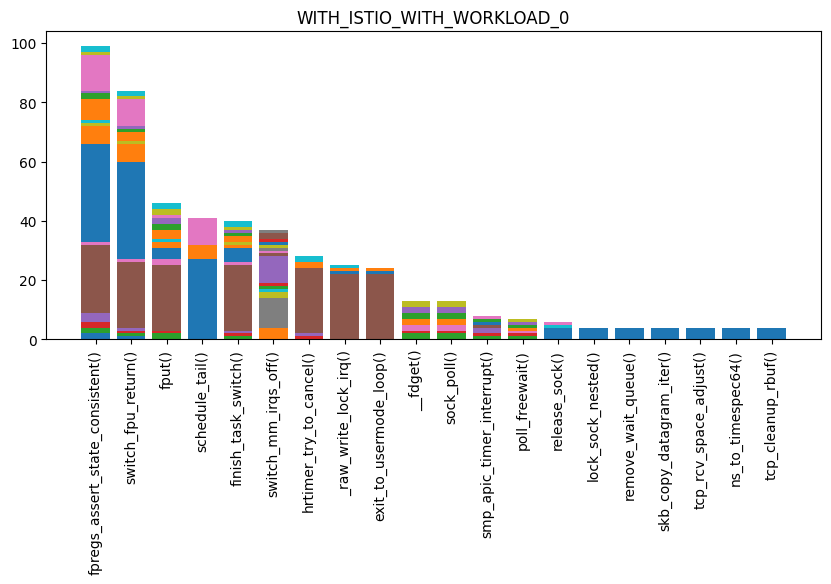

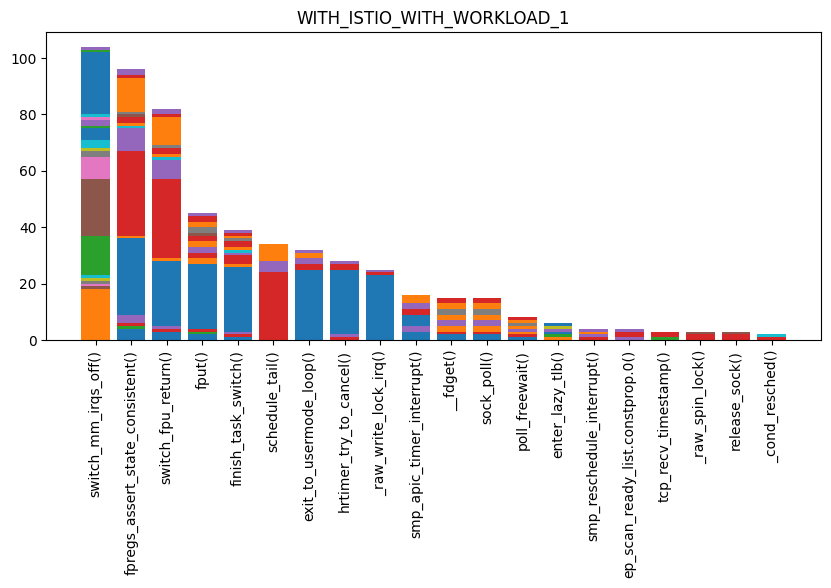

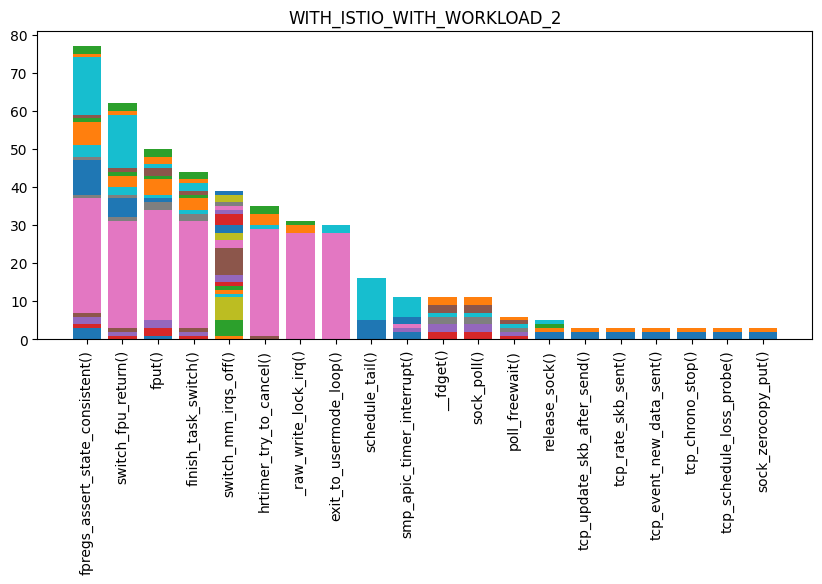

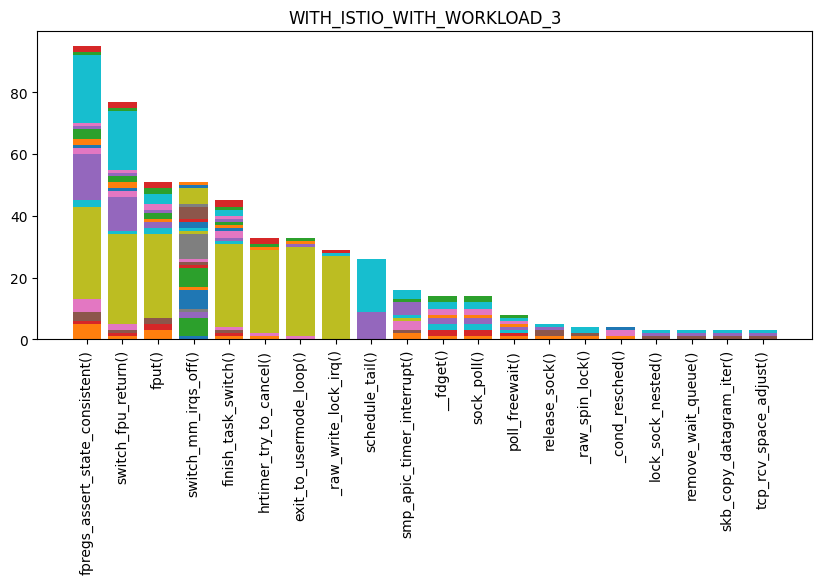

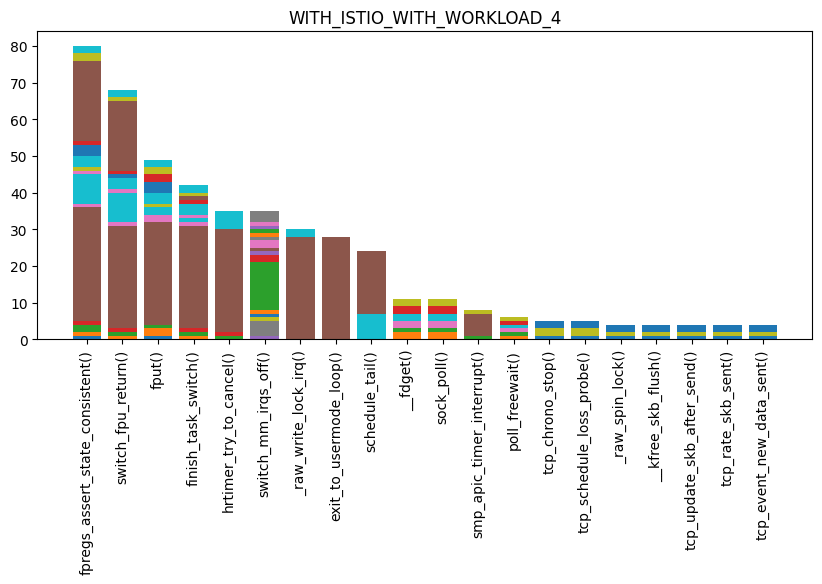

In [35]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts_per_process(runs[i],i)
    plot_stacked_counts(count, title=f"{WORKLOAD}_{i}")

Points of Note
* switch_mm_irqs_off() is the most called function call consistenctly
* The function call counts are identical across the runs
* There are a total of only around 10-13 functions called in the idle runs at the top level of the callgraph

#### Parsing the callgraph recursively

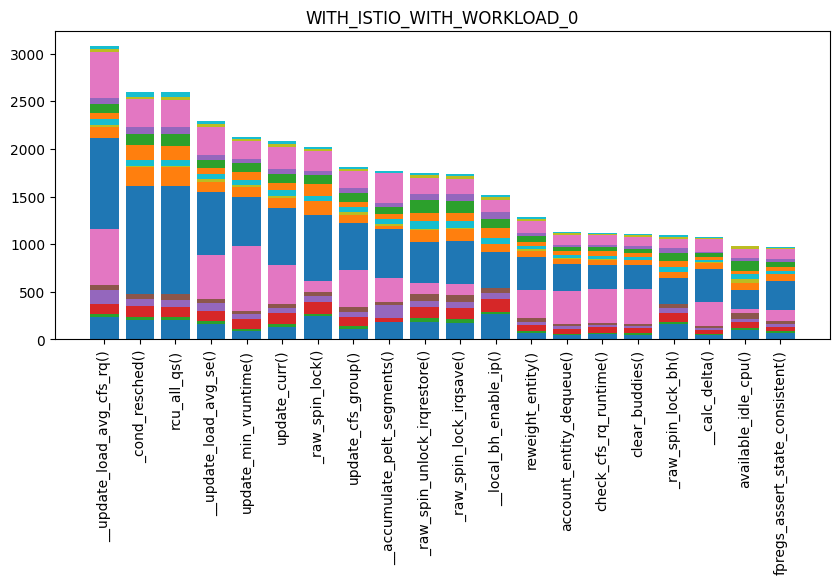

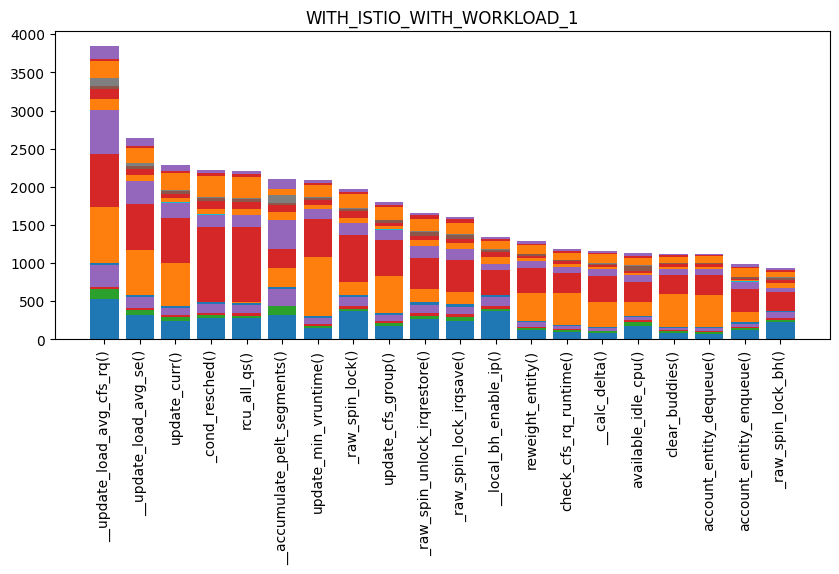

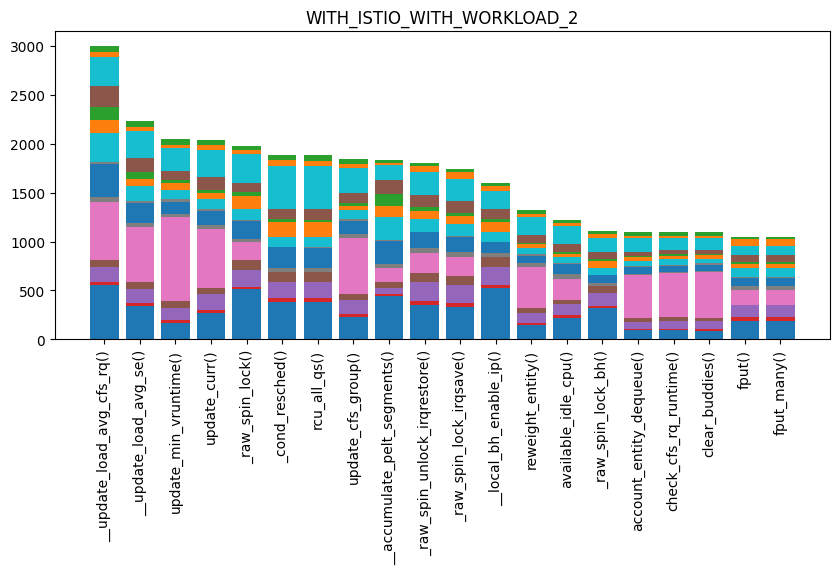

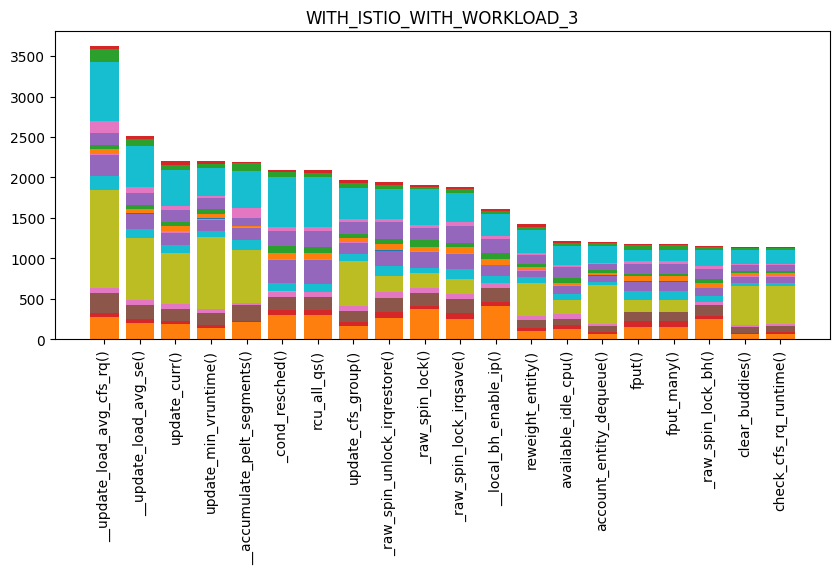

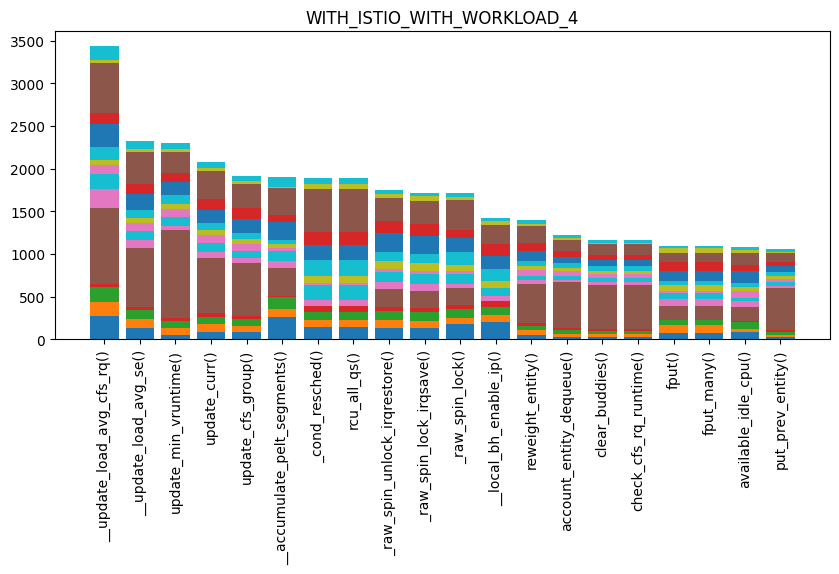

In [36]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts_per_process(runs[i],i,recurse=True)
    plot_stacked_counts(count, title=f"{WORKLOAD}_{i}")

In [7]:
function_counts = [get_function_counts(run, recurse=True) for run in runs]

with open(f"pickles/function_counts/{WORKLOAD}.pickle", "wb") as f:
    pickle.dump(function_counts, file=f)

In [8]:
print(len(function_counts[0]), len(function_counts[1]), len(function_counts[2]))

1233 1317 1260


In [9]:
for i in range(NUM_RUNS):
    for j in range(NUM_RUNS):
        if i == j:
            continue

        print(f"Calls in {i} but not in {j} ", 
            set(function_counts[i].keys()).difference(set(function_counts[j].keys())), sep="\n", end="\n")
        print()

Calls in 0 but not in 1 
{'do_wp_page()', 'destroy_context_ldt()', 'get_vma_policy.part.0()', 'page_move_anon_rmap()', 'kick_ilb()', 'swake_up_locked.part.0()', 'do_async_page_fault()', 'free_pages.part.0()', 'page_add_new_anon_rmap()', 'ptep_set_access_flags()', 'free_pcp_prepare()', 'housekeeping_cpumask()', 'page_cpupid_xchg_last()', 'free_unref_page_prepare.part.0()', 'down_read_trylock()', 'reuse_swap_page()', 'mem_cgroup_try_charge()', 'vm_normal_page()', 'mem_cgroup_commit_charge()', 'do_anonymous_page()', 'queued_read_lock_slowpath()', '__handle_mm_fault()', 'swake_up_one()', 'pgd_free()', 'mem_cgroup_throttle_swaprate()', 'update_nohz_stats()', '__count_memcg_events()', 'kthread_blkcg()', 'lru_cache_add_active_or_unevictable()', 'pmd_devmap_trans_unstable()', '__page_set_anon_rmap()', '__lru_cache_add()', 'handle_mm_fault()', 'uncharge_page()', 'mem_cgroup_charge_statistics()', '__free_pages()', 'rcu_gp_kthread_wake()', 'mem_cgroup_try_charge_delay()', 'free_pages()', 'alloc_p

In [10]:
def get_count_diff(function_counts):
    count_diff = {}
    for i in range(NUM_RUNS):
        for j in range(NUM_RUNS):
            if i==j:
                continue
            count_diff[f"{i}-{j}"]= {}
            for function in function_counts[i].keys():
                lhs = function_counts[i].get(function, 0) 
                rhs = function_counts[j].get(function, 0)
                if lhs <= rhs: 
                    continue
                count_diff[f"{i}-{j}"][function] = (lhs - rhs) / lhs * 100
    return count_diff


In [11]:
diff_count = get_count_diff(function_counts=function_counts)

In [12]:
[(x, diff_count["0-1"][x]) for x in sorted(diff_count["0-1"], key=lambda x: diff_count["0-1"][x], reverse=True)]

[('__mmdrop()', 100.0),
 ('pgd_free()', 100.0),
 ('free_pages()', 100.0),
 ('free_pages.part.0()', 100.0),
 ('__free_pages()', 100.0),
 ('destroy_context_ldt()', 100.0),
 ('kick_ilb()', 100.0),
 ('housekeeping_cpumask()', 100.0),
 ('rcu_report_qs_rnp()', 100.0),
 ('rcu_gp_kthread_wake()', 100.0),
 ('swake_up_one()', 100.0),
 ('swake_up_locked.part.0()', 100.0),
 ('update_nohz_stats()', 100.0),
 ('do_async_page_fault()', 100.0),
 ('do_page_fault()', 100.0),
 ('__do_page_fault()', 100.0),
 ('down_read_trylock()', 100.0),
 ('handle_mm_fault()', 100.0),
 ('mem_cgroup_from_task()', 100.0),
 ('__count_memcg_events()', 100.0),
 ('__handle_mm_fault()', 100.0),
 ('pmd_devmap_trans_unstable()', 100.0),
 ('do_wp_page()', 100.0),
 ('vm_normal_page()', 100.0),
 ('reuse_swap_page()', 100.0),
 ('page_trans_huge_mapcount()', 100.0),
 ('page_move_anon_rmap()', 100.0),
 ('unlock_page()', 100.0),
 ('page_cpupid_xchg_last()', 100.0),
 ('ptep_set_access_flags()', 100.0),
 ('do_anonymous_page()', 100.0),
 (

In [13]:
[(x, diff_count["0-2"][x]) for x in sorted(diff_count["0-2"], key=lambda x: diff_count["0-2"][x], reverse=True)]

[('_get_random_bytes.part.0()', 100.0),
 ('crng_make_state()', 100.0),
 ('crng_fast_key_erasure()', 100.0),
 ('can_migrate_task()', 100.0),
 ('kthread_is_per_cpu()', 100.0),
 ('d_hash_and_lookup()', 100.0),
 ('full_name_hash()', 100.0),
 ('d_lookup()', 100.0),
 ('cgroup_release()', 100.0),
 ('pids_release()', 100.0),
 ('pids_cancel.constprop.0()', 100.0),
 ('posix_cpu_timers_exit()', 100.0),
 ('cleanup_timers()', 100.0),
 ('add_device_randomness()', 100.0),
 ('detach_pid()', 100.0),
 ('__change_pid()', 100.0),
 ('free_pid()', 100.0),
 ('flush_sigqueue()', 100.0),
 ('__cleanup_sighand()', 100.0),
 ('release_thread()', 100.0),
 ('put_task_struct_rcu_user()', 100.0),
 ('proc_exit_connector()', 100.0),
 ('mpol_put_task_policy()', 100.0),
 ('__put_page()', 100.0),
 ('__put_compound_page()', 100.0),
 ('PageHuge()', 100.0),
 ('__page_cache_release()', 100.0),
 ('free_compound_page()', 100.0),
 ('mem_cgroup_uncharge()', 100.0),
 ('exit_rcu()', 100.0),
 ('exit_tasks_rcu_finish()', 100.0),
 ('ta

In [14]:
[(x, diff_count["1-0"][x]) for x in sorted(diff_count["1-0"], key=lambda x: diff_count["1-0"][x], reverse=True)]

[('sched_cfs_period_timer()', 100.0),
 ('update_group_capacity()', 100.0),
 ('mempolicy_slab_node()', 100.0),
 ('__cpuset_node_allowed()', 100.0),
 ('new_slab()', 100.0),
 ('allocate_slab()', 100.0),
 ('get_random_u32()', 100.0),
 ('setup_object_debug.isra.0()', 100.0),
 ('tcp_delack_timer()', 100.0),
 ('tcp_delack_timer_handler()', 100.0),
 ('iptable_raw_hook [iptable_raw]()', 100.0),
 ('comment_mt [xt_comment]()', 100.0),
 ('mark_tg [xt_mark]()', 100.0),
 ('mark_mt [xt_mark]()', 100.0),
 ('iptable_mangle_hook [iptable_mangle]()', 100.0),
 ('iptable_filter_hook [iptable_filter]()', 100.0),
 ('conntrack_mt_v3 [xt_conntrack]()', 100.0),
 ('conntrack_mt [xt_conntrack]()', 100.0),
 ('ip_sabotage_in [br_netfilter]()', 100.0),
 ('delayed_work_timer_fn()', 100.0),
 ('__queue_work()', 100.0),
 ('get_work_pool()', 100.0),
 ('insert_work()', 100.0),
 ('blk_stat_timer_fn()', 100.0),
 ('wb_timer_fn()', 100.0),
 ('scale_up()', 100.0),
 ('rq_depth_scale_up()', 100.0),
 ('rwb_arm_timer()', 100.0),
 

In [15]:
[(x, diff_count["2-0"][x]) for x in sorted(diff_count["2-0"], key=lambda x: diff_count["2-0"][x], reverse=True)]

[('tcp_try_rmem_schedule()', 100.0),
 ('tcp_delack_timer()', 100.0),
 ('tcp_delack_timer_handler()', 100.0),
 ('__note_gp_changes()', 100.0),
 ('rcu_advance_cbs()', 100.0),
 ('rcu_segcblist_advance()', 100.0),
 ('rcu_do_batch()', 100.0),
 ('rcu_segcblist_extract_done_cbs()', 100.0),
 ('rcu_cblist_dequeue()', 100.0),
 ('dst_destroy_rcu()', 100.0),
 ('dst_destroy()', 100.0),
 ('ipv4_dst_destroy()', 100.0),
 ('i_callback()', 100.0),
 ('sock_free_inode()', 100.0),
 ('file_free_rcu()', 100.0),
 ('epi_rcu_free()', 100.0),
 ('rcu_segcblist_insert_done_cbs()', 100.0),
 ('rcu_segcblist_insert_count()', 100.0),
 ('delayed_put_pid()', 100.0),
 ('put_pid_ns()', 100.0),
 ('delayed_put_task_struct()', 100.0),
 ('__put_task_struct()', 100.0),
 ('cgroup_free()', 100.0),
 ('task_numa_free()', 100.0),
 ('security_task_free()', 100.0),
 ('yama_task_free()', 100.0),
 ('yama_ptracer_del()', 100.0),
 ('apparmor_task_free()', 100.0),
 ('exit_creds()', 100.0),
 ('key_put()', 100.0),
 ('profile_handoff_task()'

In [16]:
[(x, diff_count["2-1"][x]) for x in sorted(diff_count["2-1"], key=lambda x: diff_count["2-1"][x], reverse=True)]

[('rcu_report_qs_rnp()', 100.0),
 ('tcp_try_rmem_schedule()', 100.0),
 ('dst_destroy_rcu()', 100.0),
 ('dst_destroy()', 100.0),
 ('ipv4_dst_destroy()', 100.0),
 ('do_async_page_fault()', 100.0),
 ('do_page_fault()', 100.0),
 ('__do_page_fault()', 100.0),
 ('down_read_trylock()', 100.0),
 ('handle_mm_fault()', 100.0),
 ('mem_cgroup_from_task()', 100.0),
 ('__count_memcg_events()', 100.0),
 ('__handle_mm_fault()', 100.0),
 ('pmd_devmap_trans_unstable()', 100.0),
 ('do_wp_page()', 100.0),
 ('vm_normal_page()', 100.0),
 ('reuse_swap_page()', 100.0),
 ('page_trans_huge_mapcount()', 100.0),
 ('page_move_anon_rmap()', 100.0),
 ('unlock_page()', 100.0),
 ('page_cpupid_xchg_last()', 100.0),
 ('ptep_set_access_flags()', 100.0),
 ('__mmdrop()', 100.0),
 ('pgd_free()', 100.0),
 ('free_pages()', 100.0),
 ('free_pages.part.0()', 100.0),
 ('__free_pages()', 100.0),
 ('destroy_context_ldt()', 100.0),
 ('tw_timer_handler()', 100.0),
 ('inet_twsk_kill()', 100.0),
 ('inet_twsk_bind_unhash()', 100.0),
 ('

In [17]:
[(x, diff_count["1-2"][x]) for x in sorted(diff_count["1-2"], key=lambda x: diff_count["1-2"][x], reverse=True)]

[('sched_cfs_period_timer()', 100.0),
 ('update_group_capacity()', 100.0),
 ('_get_random_bytes.part.0()', 100.0),
 ('crng_make_state()', 100.0),
 ('crng_fast_key_erasure()', 100.0),
 ('mempolicy_slab_node()', 100.0),
 ('__cpuset_node_allowed()', 100.0),
 ('new_slab()', 100.0),
 ('allocate_slab()', 100.0),
 ('get_random_u32()', 100.0),
 ('setup_object_debug.isra.0()', 100.0),
 ('eventfd_poll()', 100.0),
 ('eventfd_read()', 100.0),
 ('process_timeout()', 100.0),
 ('iptable_raw_hook [iptable_raw]()', 100.0),
 ('comment_mt [xt_comment]()', 100.0),
 ('mark_tg [xt_mark]()', 100.0),
 ('mark_mt [xt_mark]()', 100.0),
 ('iptable_mangle_hook [iptable_mangle]()', 100.0),
 ('iptable_filter_hook [iptable_filter]()', 100.0),
 ('conntrack_mt_v3 [xt_conntrack]()', 100.0),
 ('conntrack_mt [xt_conntrack]()', 100.0),
 ('ip_sabotage_in [br_netfilter]()', 100.0),
 ('blk_stat_timer_fn()', 100.0),
 ('wb_timer_fn()', 100.0),
 ('scale_up()', 100.0),
 ('rq_depth_scale_up()', 100.0),
 ('rwb_arm_timer()', 100.0),

### Conclusion
* There is not a signifiicant difference between the counts of the various calls.
* Especially in without-istio-without-workload, most calls are seen very infrequently 
* The most frequent calls can be noted and assigned low weightage in future anlaysis

In [40]:
def get_process_latency(run, run_no, blacklist=FUNC_BLACKLIST):
    latency = {}
    process_count={}
    pids = get_pid_mapping(f'{WORKLOAD}/{run_no}.saved_cmdlines')
    print(blacklist)

    def update_latency(function,pid):
        
        # for call in data:
        func_name = function['function_name']
        if func_name not in blacklist:   
            latency[func_name] = latency.get(func_name, {})        
            latency[func_name][pid] = latency.get(func_name).get(pid,0) + function['time']
            for child in function['children']:
                    latency[func_name][pid] -= child['time']
        for child in function["children"]:
                update_latency(child,pid)

    
    for pid in run:
        for function in run[pid]:
            update_latency(function,pid)
    for function,data in latency.items():
        process_count[function]={}
        for pid in data:
            if pid in pids:
                process_count[function][pids[pid]]=process_count.get(function).get(pids[pid],0) + latency[function][pid]
                process_count[function]['total']=process_count.get(function).get('total',0) + latency[function][pid]
        if(len(process_count[function])==0):
            del process_count[function]
                

    return process_count

In [41]:
runs = get_runs()

{'BLANK', 'schedule()', 'do_syscall_64()'}
{'BLANK', 'schedule()', 'do_syscall_64()'}
{'BLANK', 'schedule()', 'do_syscall_64()'}
{'BLANK', 'schedule()', 'do_syscall_64()'}
{'BLANK', 'schedule()', 'do_syscall_64()'}


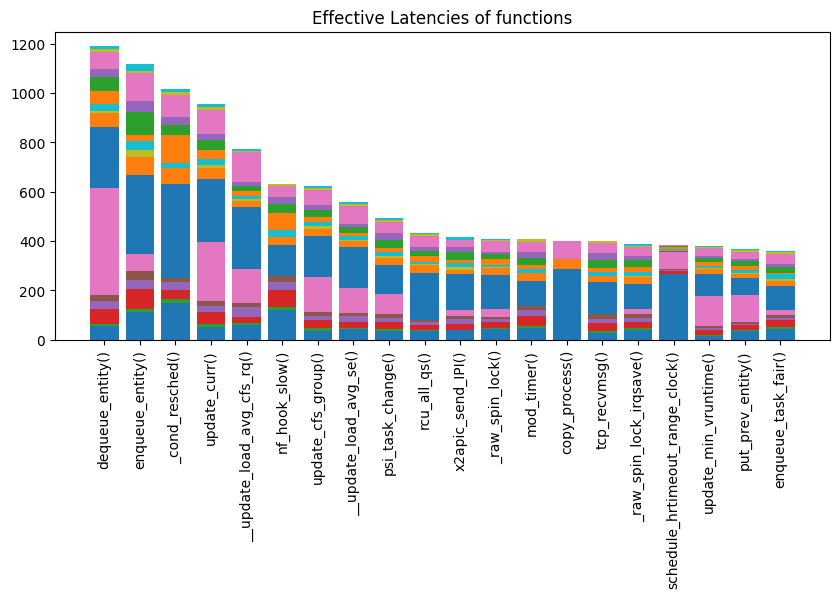

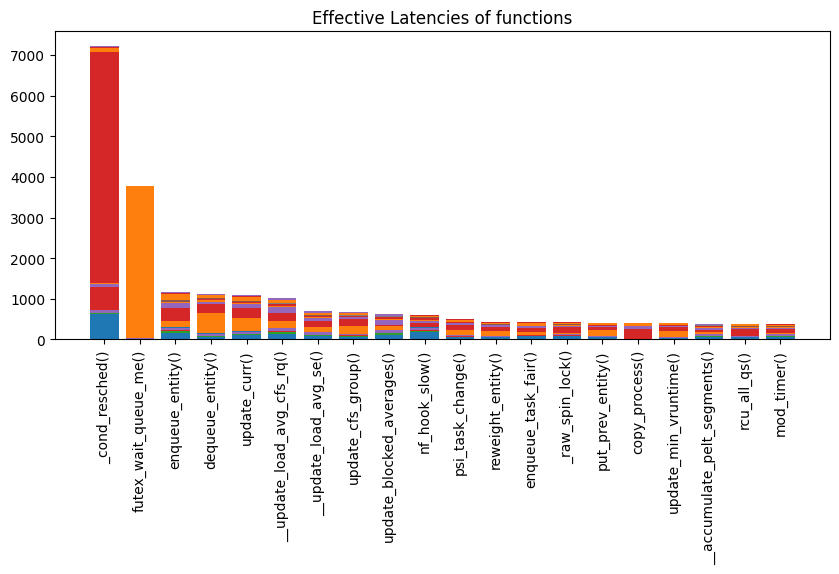

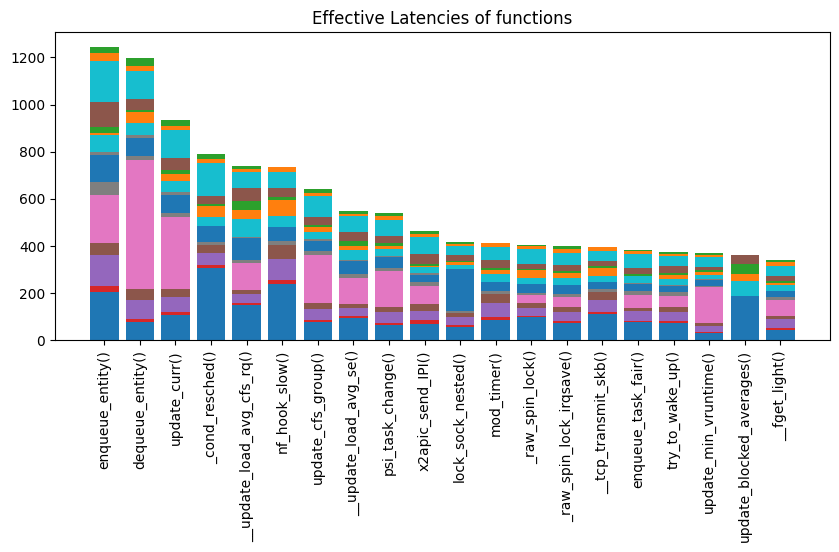

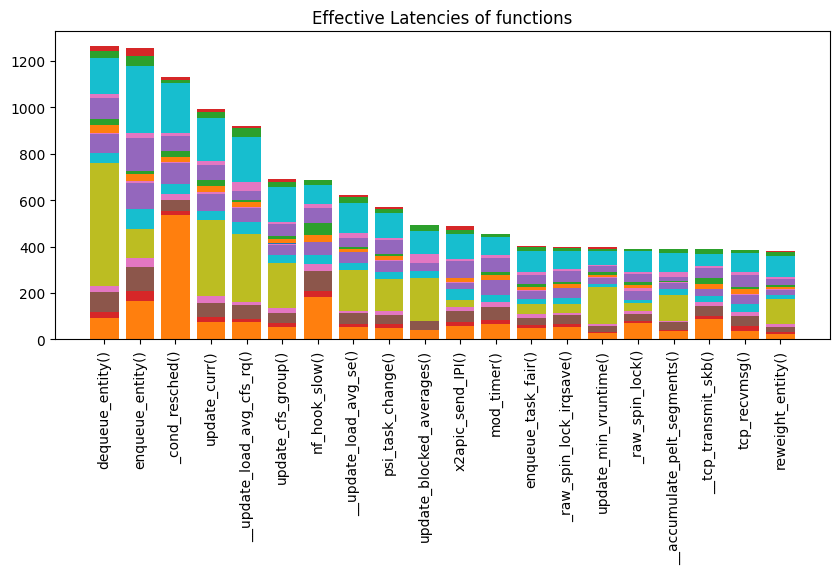

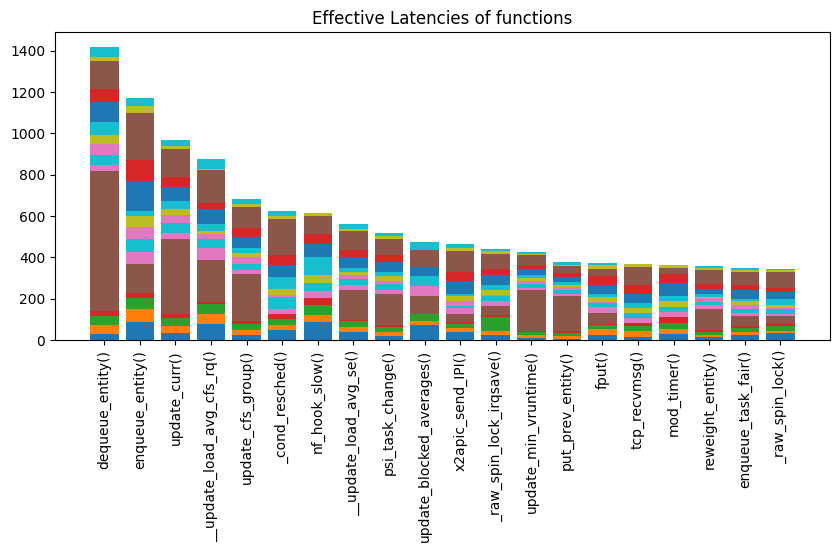

In [42]:
latencies = []
for i in range(NUM_RUNS):
    latencies.append(get_process_latency(runs[i],i))

for latency in latencies:
    plot_stacked_counts(latency, title="Effective Latencies of functions") # TODO: pick a better term

In [21]:
def get_pid_mapping(file):
    pid_mapping={}
    with open(file,'r') as f:
        for line in f.readlines():
            
            pid,*name= line.split()
            if(type(name)==list):
                name=' '.join(name)
            pid_mapping[pid]=name
            
    return pid_mapping

In [22]:
def get_latency_by_pid(run,function=None):
    latency = {}
    
    def update_latency(pid,data):
        
        for call in data:
            function_name = call['function_name']
            if not function or function_name == function:              
                latency[pid] = latency.get(pid, 0) + call['time']
                
                for child in call['children']:
                    latency[pid] -= child['time']

            update_latency(pid,call['children'])
    
    for pid,data in run.items():
        update_latency(pid,data)

    return latency

In [23]:
NUM_RUNS=5

In [24]:
cnt=[]
for i in range(NUM_RUNS):
    count={}
    pid_map=get_pid_mapping(f'{WORKLOAD}/{i}.saved_cmdlines')
    # latency=(get_latency_by_pid(runs[i],'ipt_do_table [ip_tables]()'))
    # for pid in latency.keys():
    #     if pid in pid_map:
    #         count[pid_map[pid]]=count.get(pid_map[pid],0)+latency[pid]
    #     else:
    #         cnt.append(pid)
    # print(count)